
Numerical optimization
======================

Silent substitution can be approached as a [constrained numerical optimization](https://en.wikipedia.org/wiki/Constrained_optimization) problem of the form:

\begin{equation}
\begin{array}{rrclcl}
& \underset{x \in \mathbb{R}^{n}}{\text{minimize}}
&  f(x) \\
& \text{subject to}
& g^{L} \le g(x) \le g^{U} \\
& & x^{L} \le x \le x^{U} ,
\end{array}
\end{equation}

where $x \in \mathbb{R}^{n}$ are the optimization variables (i.e., the primary input weights) whose lower and upper bounds, $x^{L}$ and $x^{U}$, are between 0 and 1 to ensure that the solution is within the gamut of the device, $f(x)$ is the objective function that aims to maximise contrast of the target photoreceptor(s), and $g(x)$ is a constraint function that calculates contrast for the silenced photoreceptor(s), where $g^{L}$ and $g^{U}$ should be zero. In all cases, $x$ is a vector containing the primary input weights. 

`pysilsub.problems.SilentSubstitutionProblem` has an `.optim_solve()` method that uses `SciPy`'s optimisation algorithms to solve a defined problem. By default, it performs a local optimisation with `scipy.optimize.minimize` using the `SLSQP` [sequential quadratic least squares programming](https://docs.scipy.org/doc/scipy-1.8.0/html-scipyorg/reference/optimize.minimize-slsqp.html) solver. 

The objective function, $f(x)$, and the contrast constraint function, $g(x)$, are built into the problem class and are conditioned by the values given to the properties. 


Basic example
-------------

************************************************************
*************** Silent Substitution Problem ****************
************************************************************
Device: STLAB_1 (binocular, left eye)
Ignoring: ['rh']
Minimising: ['sc', 'mc', 'lc']
Modulating: ['mel']
Target contrast: [ 0.5]
Background: None


> No background specified, will optimise background.
> Performing local optimization with SLSQP.


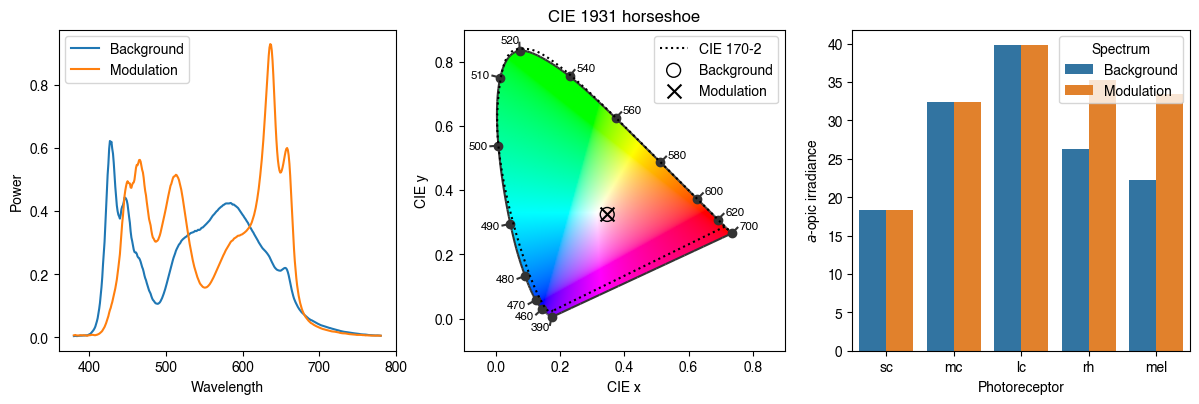

In [4]:
from pysilsub.problems import SilentSubstitutionProblem as SSP

# Instantiate the problem class
ssp = SSP.from_package_data('STLAB_1_York')

# Define problem
ssp.ignore = ['rh']
ssp.modulate = ['mel']
ssp.minimize = ['sc', 'mc', 'lc']
ssp.target_contrast = .5
ssp.print_problem()

# Find solution
solution = ssp.optim_solve(**{'options':{'disp':False}})

# Plot solution
fig = ssp.plot_solution(solution.x)

In [5]:
# Look at the actual contrast values
ssp.print_photoreceptor_contrasts(solution.x)

sc     0.000457
mc     0.000533
lc    -0.000604
rh     0.342105
mel    0.500160
dtype: float64



Maximising contrast
-------------------

If you want `.optim_solve(...)` to maximise contrast rather than aim for a target value, you can set the `target_contrast` property to `'max'` or `'min'`.

************************************************************
*************** Silent Substitution Problem ****************
************************************************************
Device: STLAB_1 (binocular, left eye)
Ignoring: ['rh']
Minimising: ['sc', 'mc', 'lc']
Modulating: ['mel']
Target contrast: [inf]
Background: None


> No background specified, will optimise background.
> Aiming to maximise contrast.
> Performing local optimization with SLSQP.


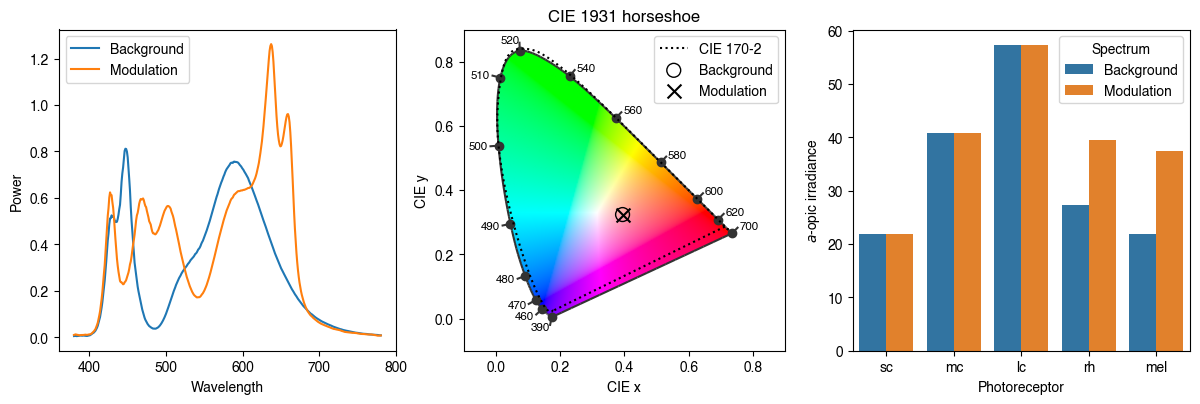

In [9]:
ssp.target_contrast = 'max'
ssp.print_problem()

# Find solution
solution = ssp.optim_solve(**{'options':{'disp':False}})

# Plot solution
_ = ssp.plot_solution(solution.x)

In [10]:
ssp.print_photoreceptor_contrasts(solution.x)

sc     0.000005
mc     0.000025
lc    -0.000035
rh     0.442191
mel    0.706693
dtype: float64



### Optimising the background

Note that in the above examples, both the background and modulation spectrum were optimised. However, It often makes sense to stick with a specific background spectrum, particularly if you plan on targeting different photoreceptors in the same experiment. But when you specify a background spectrum, `.optim_solve()` will only optimize the modulation spectrum. This is a big constraint on the optimisation and is why in this case we only got about 21% contrast on melanopsin.

If you don't care what the background spectrum is, set the `background` property to `None`. `.optim_solve()` will now also optimise the background and should be able to find more contrast.

************************************************************
*************** Silent Substitution Problem ****************
************************************************************
Device: STLAB_1 (binocular, left eye)
Ignoring: ['rh']
Minimising: ['sc', 'mc', 'lc']
Modulating: ['mel']
Target contrast: [ 0.15]
Background: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]


> Performing local optimization with SLSQP.


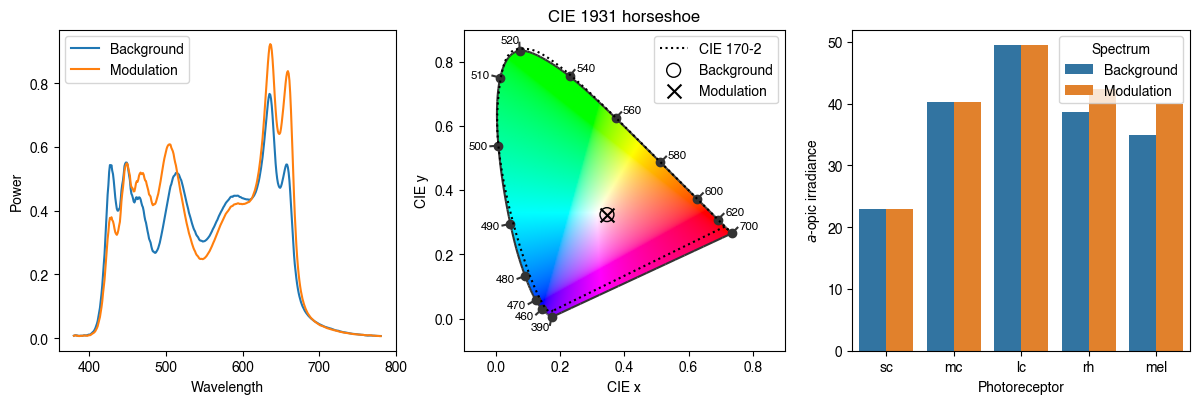

In [18]:
ssp.background = [.5] * ssp.nprimaries
ssp.target_contrast = .15
ssp.print_problem()
solution = ssp.optim_solve(**{'options':{'disp':False}})
_ = ssp.plot_solution(solution.x)

In [19]:
ssp.print_photoreceptor_contrasts(solution.x)

sc    -0.000239
mc     0.000599
lc    -0.000013
rh     0.095432
mel    0.140064
dtype: float64



Local vs. global optimisation
-----------------------------

By default, `.optim_solve()` uses *Scipy's* `minimize` function, which is a *local* minimizer. It starts with an initial random guess for the primary inputs and works from that point to minimize the objective function (which in this case was to maximize contrast). 

Due to the random nature of the starting point in the function landscape, the minimum it finds is unlikely to be the global minimum. 

If you have enough time, you can tell `.optim_solve()` to search for the global minimum, in which case it will use *Scipy's* `basinhopping` algorithm to perform a series of local searches, each with a different starting point. 


************************************************************
*************** Silent Substitution Problem ****************
************************************************************
Device: STLAB_1 (binocular, left eye)
Ignoring: ['rh']
Minimising: ['sc', 'mc', 'lc']
Modulating: ['mel']
Target contrast: [ 0.15]
Background: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]


> Performing global optimization with basinhopping and SLSQP
basinhopping step 0: f 0.00735265
basinhopping step 1: f 0.0111026 trial_f 0.0111026 accepted 1  lowest_f 0.00735265
basinhopping step 2: f 7.27183e-06 trial_f 7.27183e-06 accepted 1  lowest_f 7.27183e-06
found new global minimum on step 2 with function value 7.27183e-06
basinhopping step 3: f 3.59535e-05 trial_f 3.59535e-05 accepted 1  lowest_f 7.27183e-06
basinhopping step 4: f 2.29873e-06 trial_f 2.29873e-06 accepted 1  lowest_f 2.29873e-06
found new global minimum on step 4 with function value 2.29873e-06
basinhopping step 5: f 1.64255e-07 trial_f 1.

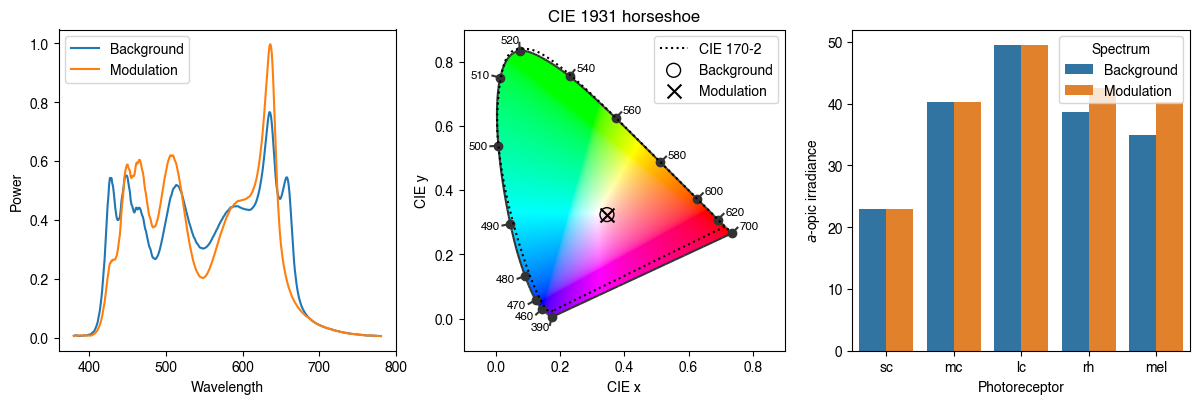

In [23]:
ssp.print_problem()
solution = ssp.optim_solve(global_search=True, niter=10)
fig = ssp.plot_solution(solution.x)

In [24]:
ssp.print_photoreceptor_contrasts(solution.x)

sc    -0.000066
mc     0.000100
lc    -0.000129
rh     0.100753
mel    0.149595
dtype: float64



Using an external optimiser
---------------------------

For example, ipopt is a fast nonlinear optimizer. 

*'Ipopt (Interior Point OPTimizer, pronounced eye-pea-Opt) is a software package for large-scale nonlinear optimization. cyipopt is a python wrapper around Ipopt. It enables using Ipopt from the comfort of the great Python scripting language. Ipopt is available from the COIN-OR initiative, under the Eclipse Public License (EPL).'*

In [2]:
# from cyipopt import minimize_ipopt

# # Define problem
# ssp.ignore = ['rh']
# ssp.modulate = ['mel']
# ssp.minimize = ['sc', 'mc', 'lc']
# ssp.background = [.5] * ssp.nprimaries
# ssp.target_contrast = None
# ssp.print_problem()

# # Set up optimisation
# result = minimize_ipopt(
#     fun=ssp.objective_function,
#     x0=ssp.initial_guess_x0(),
#     args=(),
#     bounds=ss.bounds,
#     constraints=constraints,
#     tol=1e-5,
#     options={b"print_level": 5, b"constr_viol_tol": 1e-5},
# )
